In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/chandniagarwal/Gan_Classifier.git

Cloning into 'Gan_Classifier'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 13), reused 46 (delta 11), pack-reused 0
Receiving objects: 100% (48/48), 835.10 KiB | 2.65 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [3]:
!mkdir training
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/recon /content/training/recon
!cp -r /content/drive/MyDrive/researchwork_15.9.203/training_dataset/celebagt /content/training/ground
!cp -r /content/drive/MyDrive/researchwork_15.9.203/testing /content/testing

In [4]:
import sys
sys.path.append('/content/Gan_Classifier/src')
import glob
import os
import numpy as np
import cv2
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import *
from keras import optimizers


from keras.models import Sequential
from keras.layers import Input, Dense, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import time
import random
import seaborn as sns
from DatasetCreation import DatasetCreation
from Model import Model
from ElmModel import elm
from numba import cuda

In [5]:
tf.random.set_seed(
    42
)
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
list_images=[]
labels=[]

In [15]:
# Testing Data Location
test_gt = "/content/drive/MyDrive/researchwork_15.9.203/testing/gt"
test_gen = "/content/drive/MyDrive/researchwork_15.9.203/testing/gen"
test_ec = "/content/drive/MyDrive/researchwork_15.9.203/testing/ec"
test_vqvae = "/content/drive/MyDrive/researchwork_15.9.203/testing/vqvae"
test_mask = "/content/drive/MyDrive/imageclassificationmodel/dataset/mask2000"
test_unmask = "/content/drive/MyDrive/imageclassificationmodel/dataset/gt2000"


In [7]:
# test_gt = '/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/e3'
# test_vqvae='/content/drive/MyDrive/imageclassificationmodel/dataset/pixgan20epochs/g3'

In [8]:
# Training Data Location
train_gt='/content/training/ground'
train_recon='/content/training/recon'

In [9]:
# training Data
image_loc_ground = glob.glob(train_gt+"/*.jpg")
labels = len(image_loc_ground) * ["ground"]
image_loc_recon = glob.glob(train_recon+"/*.jpg")

labels += len(image_loc_recon) * ["recon"]
image_loc = image_loc_ground + image_loc_recon

training_dataset = DatasetCreation(image_loc, labels, "one_hot")
# for 152 layer
training_dataset_152_layer = DatasetCreation(
    image_loc, labels, "one_hot", tf.keras.applications.resnet50.preprocess_input
)
print(training_dataset.images.shape)
print(training_dataset.labels.shape)

_________Loading Images__________


100%|██████████| 7178/7178 [00:24<00:00, 297.57it/s]


_________Loading Images__________


100%|██████████| 7178/7178 [00:13<00:00, 546.13it/s]


(7178, 224, 224, 3)
(7178, 2)


## load model

In [10]:
def load_model(model_function, trainable:bool):
  start = time.time()
  # load resnet model
  base_model = model_function(
      input_shape=(224,224,3),
      include_top=False,
      weights='imagenet'
  )

  for layer in base_model.layers:
      layer.trainable = trainable

  # Create your binary classification layers on top of the base model
  x = base_model.output
  x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = tf.keras.layers.Dense(1000, activation='relu')(x) # intermediate hidden layer
  x = tf.keras.layers.Dropout(0.2)(x)
  predictions = tf.keras.layers.Dense(2, activation='softmax')(x)  # Binary classification output layer

  # Combine the base model and your custom layers into a new model
  model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

  print('Running time: %.4f seconds' % (time.time()-start))
  return model

In [11]:
model_resnet_152_full = load_model(tf.keras.applications.ResNet152, True)
model_resnet_101_full = load_model(tf.keras.applications.ResNet101, True)
model_resnet_50_full = load_model(tf.keras.applications.ResNet50, True)

model_resnet_152_freeze = load_model(tf.keras.applications.ResNet152, False)
model_resnet_101_freeze = load_model(tf.keras.applications.ResNet101, False)
model_resnet_50_freeze = load_model(tf.keras.applications.ResNet50, False)

234698864/234698864 [==============================] - 1s 0us/step
Running time: 8.5903 seconds
171446536/171446536 [==============================] - 2s 0us/step
Running time: 5.1239 seconds
94765736/94765736 [==============================] - 0s 0us/step
Running time: 2.0372 seconds
Running time: 4.8101 seconds
Running time: 3.1090 seconds
Running time: 1.6325 seconds


In [ ]:
# # best model calculate before the notebook crashed
# model_resnet_152_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_full/weights.08-0.00-1.00.hdf5")
# model_resnet_101_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_full/weights.10-0.00-1.00.hdf5")
# model_resnet_50_full.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_full/weights.06-0.00-1.00.hdf5")
# model_resnet_152_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/152_freeze/weights.02-0.24-0.95.hdf5")
# model_resnet_101_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/101_freeze/weights.02-0.71-0.48.hdf5")
# model_resnet_50_freeze.load_weights("/content/drive/MyDrive/final_model/checkpoint/50_freeze/weights.02-0.66-0.62.hdf5")

In [12]:
model_softmax = {
    "152_full": model_resnet_152_full,
    "101_full": model_resnet_101_full,
    "50_full": model_resnet_50_full,
    "152_freeze": model_resnet_152_freeze,
    "101_freeze": model_resnet_101_freeze,
    "50_freeze": model_resnet_50_freeze,
}
model_data = {
    "152_full": training_dataset_152_layer,
    "101_full": training_dataset,
    "50_full": training_dataset,
    "152_freeze": training_dataset_152_layer,
    "101_freeze": training_dataset,
    "50_freeze": training_dataset,
}

## Resnet Training

In [13]:
for key in model_softmax.keys():
  print("_"*10, key, "_"*50)
  model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")
  model_softmax[key].train(model_data[key].images, model_data[key].labels, batch_size=64, epoch=10)
  tf.keras.backend.clear_session()

__________ 152_full __________________________________________________
Epoch 1/10
101/101 [==============================] - 139s 284ms/step - loss: 0.7111 - accuracy: 0.7101 - val_loss: 11.4607 - val_accuracy: 0.4123 - lr: 0.0010
Epoch 2/10
101/101 [==============================] - 21s 208ms/step - loss: 0.3153 - accuracy: 0.8613 - val_loss: 2266616.5000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10
101/101 [==============================] - 21s 208ms/step - loss: 0.1903 - accuracy: 0.9259 - val_loss: 11035.4863 - val_accuracy: 0.0836 - lr: 0.0010
Epoch 4/10
101/101 [==============================] - 22s 222ms/step - loss: 0.0562 - accuracy: 0.9788 - val_loss: 2.2359 - val_accuracy: 0.7925 - lr: 5.0000e-04
Epoch 5/10
101/101 [==============================] - 23s 223ms/step - loss: 0.0426 - accuracy: 0.9854 - val_loss: 0.2627 - val_accuracy: 0.9401 - lr: 5.0000e-04
Epoch 6/10
101/101 [==============================] - 22s 223ms/step - loss: 0.0276 - accuracy: 0.9904 - val_loss: 

In [ ]:
# for key in model_softmax.keys():
#   model_softmax[key] = Model(model_softmax[key], 0.001, f'/content/drive/MyDrive/final_model/checkpoint/{key}', "categorical_crossentropy")

## Elm Training

In [16]:
for key in model_softmax.keys():
  for layer in model_softmax[key].model.layers:
      layer.trainable = False
  model_softmax[key].remove_layer(2)

In [17]:
def batch_predict(model, images, batch=32):
  array1 = []
  for idx in range(0, len(images), batch):
    array2 = model.predict(images[idx: min(len(images), idx+batch)], verbose=0)
    if len(array1)>0:
      array1 = np.concatenate((array1, array2), axis=0)
    else:
      array1 = array2
  return array1

In [18]:
model_elm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0

  model_elm[key] = elm(hidden_units=16, activation_function='relu', random_type='normal', x=Xtrain, y=Ytrain, C=0.1, elm_type='clf')
  beta, train_accuracy, running_time = model_elm[key].fit('solution2')
  print("classifier train accuracy:", train_accuracy)
  print('classifier running time:', running_time)

__________ 152_full __________
classifier train accuracy: 0.9923376985232656
classifier running time: 0.034919023513793945
__________ 101_full __________
classifier train accuracy: 0.9972137085539148
classifier running time: 0.028220415115356445
__________ 50_full __________
classifier train accuracy: 0.9981889105600446
classifier running time: 0.015026569366455078
__________ 152_freeze __________
classifier train accuracy: 0.8240456951797158
classifier running time: 0.019196271896362305
__________ 101_freeze __________
classifier train accuracy: 0.6060183895235441
classifier running time: 0.014760255813598633
__________ 50_freeze __________
classifier train accuracy: 0.5564224017832266
classifier running time: 0.01888728141784668


## Svm Training

In [19]:
model_svm = {}
for key in model_softmax.keys():
  print("_"*10, key, "_"*10)
  Xtrain = batch_predict(model_softmax[key].headless_model, model_data[key].images, 64)
  Ytrain = model_data[key].labels[...,0] == 0
  model_svm[key] = make_pipeline(SVC())
  model_svm[key].fit(Xtrain, Ytrain)
  print("Classifier train accuracy:", model_svm[key].score(Xtrain, Ytrain))

__________ 152_full __________
Classifier train accuracy: 0.994706046252438
__________ 101_full __________
Classifier train accuracy: 0.9981889105600446
__________ 50_full __________
Classifier train accuracy: 0.9987461688492616
__________ 152_freeze __________
Classifier train accuracy: 0.8722485371969908
__________ 101_freeze __________
Classifier train accuracy: 0.6447478406241293
__________ 50_freeze __________
Classifier train accuracy: 0.6051825020897186


In [20]:
#dump training data
training_dataset = None
training_dataset_152_layer = None
model_data = None

## Load Test Data

In [21]:
# test Data
image_loc_ground = glob.glob(test_gt+"/*.jpg")
label_ground = len(image_loc_ground) * ["ground"]

image_loc_gen = glob.glob(test_gen+"/*.jpg")
label_gen = len(image_loc_gen) * ["recon"]

image_loc_ec = glob.glob(test_ec+"/*.jpg")
label_ec = len(image_loc_ec) * ["recon"]

image_loc_vqvae = glob.glob(test_vqvae+"/*.jpg")
label_vqvae = len(image_loc_vqvae) * ["recon"]

test_dataset = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary"
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary"
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary"
        ),
}

test_dataset_152_layer = {
    "gen": DatasetCreation(
        image_loc_ground+image_loc_gen,
        label_ground+label_gen,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "ec": DatasetCreation(
        image_loc_ground+image_loc_ec,
        label_ground+label_ec,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
    "vqvae": DatasetCreation(
        image_loc_ground+image_loc_vqvae,
        label_ground+label_vqvae,
        "binary",
        tf.keras.applications.resnet50.preprocess_input
        ),
}
model_data = {
    "152_full": test_dataset_152_layer,
    "101_full": test_dataset,
    "50_full": test_dataset,
    "152_freeze": test_dataset_152_layer,
    "101_freeze": test_dataset,
    "50_freeze": test_dataset,
}

_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 216.72it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 231.80it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:04<00:00, 223.73it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 297.36it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 311.41it/s]


_________Loading Images__________


100%|██████████| 1000/1000 [00:03<00:00, 293.58it/s]


## Testing Resnet

In [22]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    y_result = batch_predict(model_softmax[model_name].model, model_data[model_name][key].images, 64)
    y_result = y_result[... ,0] < 0.5

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

__________ 152_full __________
__________gen__________
Accuracy 0.965
Precision: 0.974000
Recall: 0.956778
F1 score: 0.965312
__________ec__________
Accuracy 0.978
Precision: 1.000000
Recall: 0.957854
F1 score: 0.978474
__________vqvae__________
Accuracy 0.977
Precision: 0.998000
Recall: 0.957774
F1 score: 0.977473
__________ 101_full __________
__________gen__________
Accuracy 0.982
Precision: 0.998000
Recall: 0.967054
F1 score: 0.982283
__________ec__________
Accuracy 0.983
Precision: 1.000000
Recall: 0.967118
F1 score: 0.983284
__________vqvae__________
Accuracy 0.983
Precision: 1.000000
Recall: 0.967118
F1 score: 0.983284
__________ 50_full __________
__________gen__________
Accuracy 0.983
Precision: 0.978000
Recall: 0.987879
F1 score: 0.982915
__________ec__________
Accuracy 0.994
Precision: 1.000000
Recall: 0.988142
F1 score: 0.994036
__________vqvae__________
Accuracy 0.993
Precision: 0.998000
Recall: 0.988119
F1 score: 0.993035
__________ 152_freeze __________
__________gen____

## Testing ELM

__________ 152_full __________
__________gen__________
Accuracy 0.968
Precision: 0.976000
Recall: 0.960630
F1 score: 0.968254


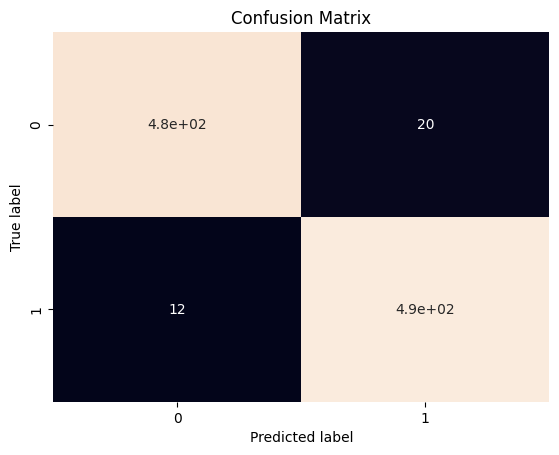

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       500
           1       0.96      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

__________ec__________
Accuracy 0.98
Precision: 1.000000
Recall: 0.961538
F1 score: 0.980392


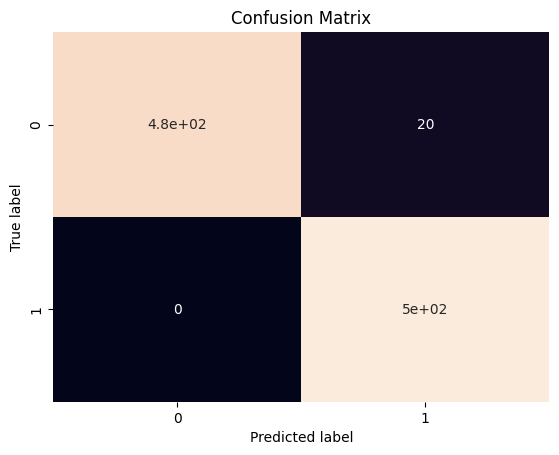

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       500
           1       0.96      1.00      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

__________vqvae__________
Accuracy 0.979
Precision: 0.998000
Recall: 0.961464
F1 score: 0.979392


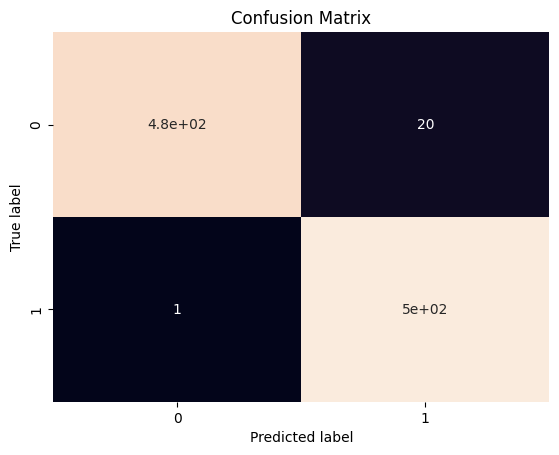

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       500
           1       0.96      1.00      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

__________ 101_full __________
__________gen__________
Accuracy 0.985
Precision: 0.996000
Recall: 0.974560
F1 score: 0.985163


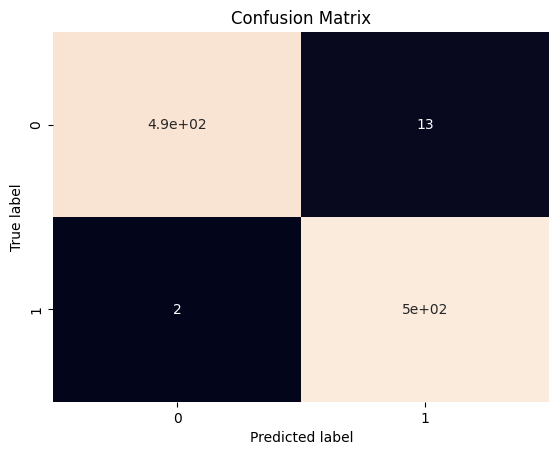

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       500
           1       0.97      1.00      0.99       500

    accuracy                           0.98      1000
   macro avg       0.99      0.98      0.98      1000
weighted avg       0.99      0.98      0.98      1000

__________ec__________
Accuracy 0.987
Precision: 1.000000
Recall: 0.974659
F1 score: 0.987167


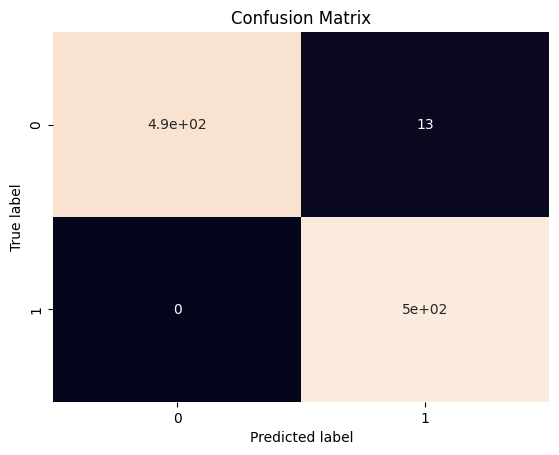

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       500
           1       0.97      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________vqvae__________
Accuracy 0.987
Precision: 1.000000
Recall: 0.974659
F1 score: 0.987167


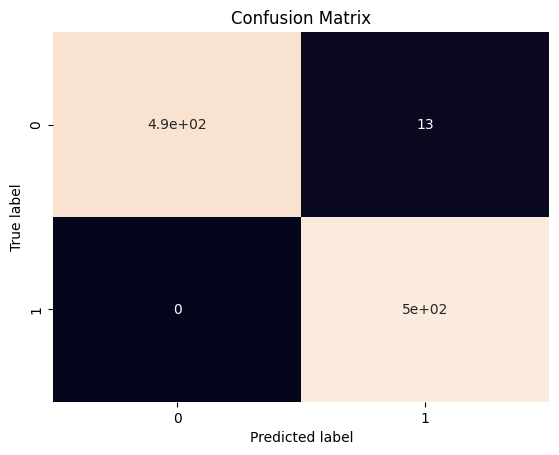

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       500
           1       0.97      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ 50_full __________
__________gen__________
Accuracy 0.981
Precision: 0.972000
Recall: 0.989817
F1 score: 0.980827


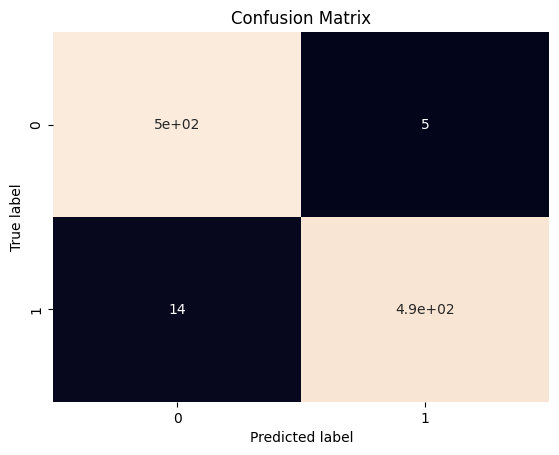

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.99      0.97      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

__________ec__________
Accuracy 0.995
Precision: 1.000000
Recall: 0.990099
F1 score: 0.995025


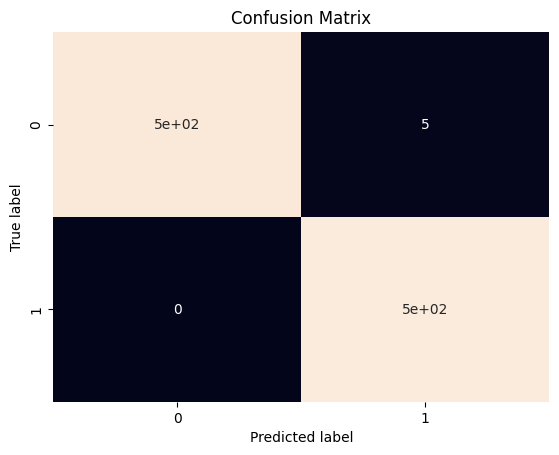

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      1.00       500

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000

__________vqvae__________
Accuracy 0.993
Precision: 0.996000
Recall: 0.990060
F1 score: 0.993021


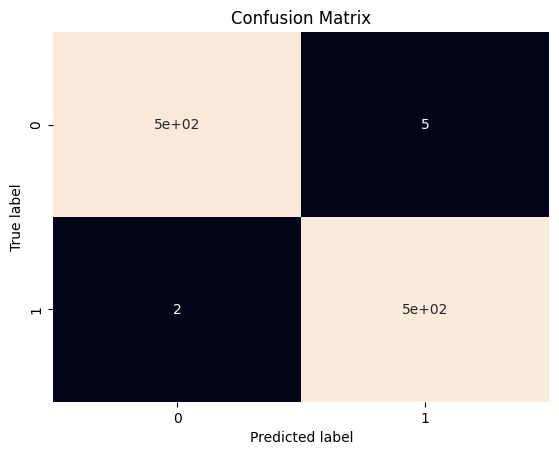

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       500
           1       0.99      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ 152_freeze __________
__________gen__________
Accuracy 0.71
Precision: 0.560000
Recall: 0.800000
F1 score: 0.658824


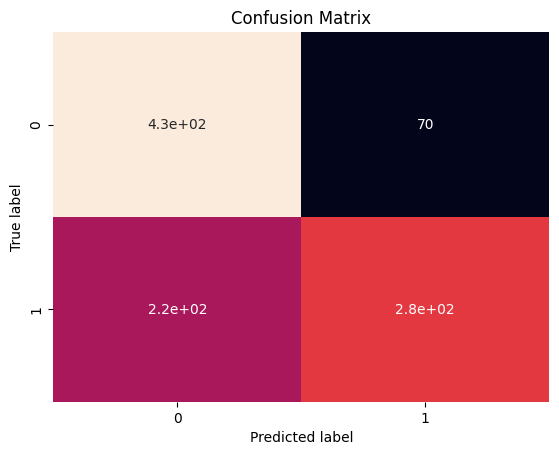

              precision    recall  f1-score   support

           0       0.66      0.86      0.75       500
           1       0.80      0.56      0.66       500

    accuracy                           0.71      1000
   macro avg       0.73      0.71      0.70      1000
weighted avg       0.73      0.71      0.70      1000

__________ec__________
Accuracy 0.919
Precision: 0.978000
Recall: 0.874776
F1 score: 0.923513


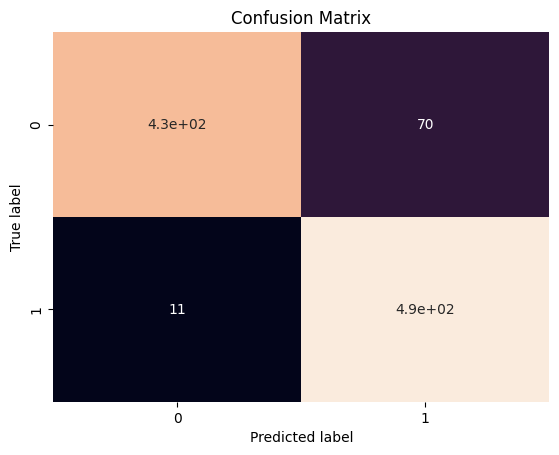

              precision    recall  f1-score   support

           0       0.98      0.86      0.91       500
           1       0.87      0.98      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

__________vqvae__________
Accuracy 0.887
Precision: 0.914000
Recall: 0.867173
F1 score: 0.889971


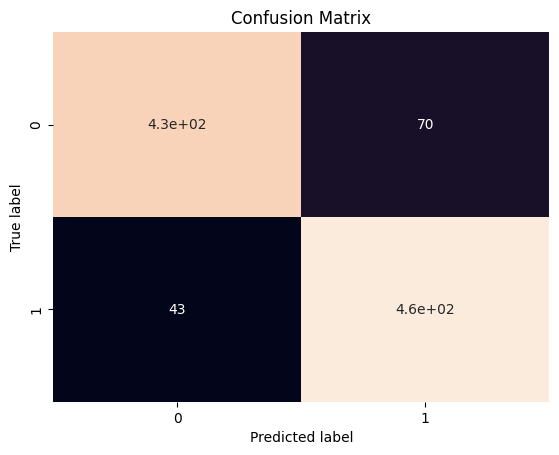

              precision    recall  f1-score   support

           0       0.91      0.86      0.88       500
           1       0.87      0.91      0.89       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000

__________ 101_freeze __________
__________gen__________
Accuracy 0.557
Precision: 0.494000
Recall: 0.565217
F1 score: 0.527215


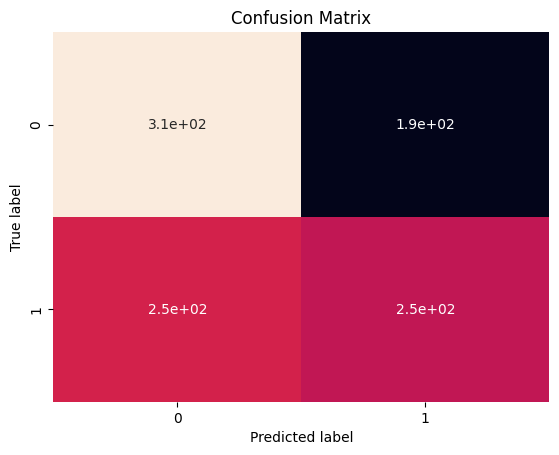

              precision    recall  f1-score   support

           0       0.55      0.62      0.58       500
           1       0.57      0.49      0.53       500

    accuracy                           0.56      1000
   macro avg       0.56      0.56      0.56      1000
weighted avg       0.56      0.56      0.56      1000

__________ec__________
Accuracy 0.651
Precision: 0.682000
Recall: 0.642185
F1 score: 0.661494


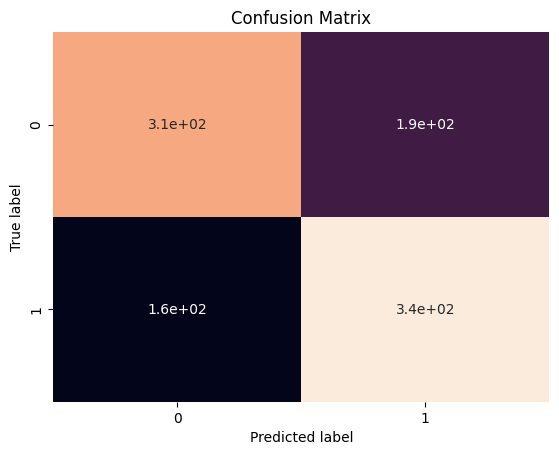

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       500
           1       0.64      0.68      0.66       500

    accuracy                           0.65      1000
   macro avg       0.65      0.65      0.65      1000
weighted avg       0.65      0.65      0.65      1000

__________vqvae__________
Accuracy 0.53
Precision: 0.440000
Recall: 0.536585
F1 score: 0.483516


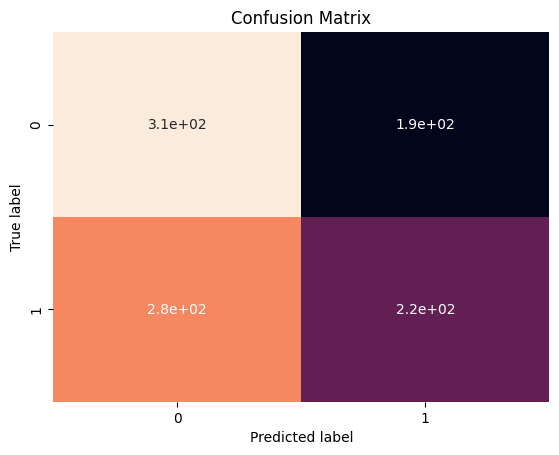

              precision    recall  f1-score   support

           0       0.53      0.62      0.57       500
           1       0.54      0.44      0.48       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000

__________ 50_freeze __________
__________gen__________
Accuracy 0.535
Precision: 0.496000
Recall: 0.537961
F1 score: 0.516129


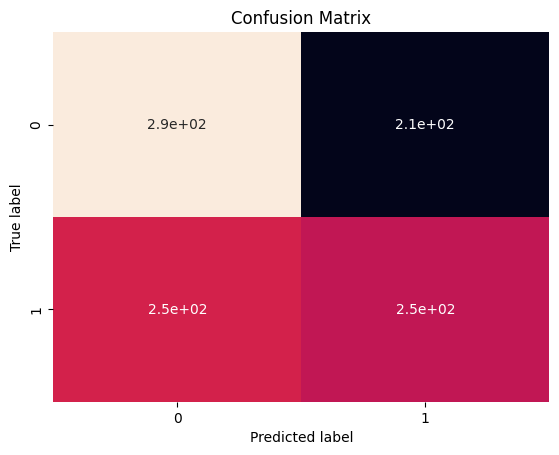

              precision    recall  f1-score   support

           0       0.53      0.57      0.55       500
           1       0.54      0.50      0.52       500

    accuracy                           0.54      1000
   macro avg       0.54      0.53      0.53      1000
weighted avg       0.54      0.54      0.53      1000

__________ec__________
Accuracy 0.607
Precision: 0.640000
Recall: 0.600375
F1 score: 0.619555


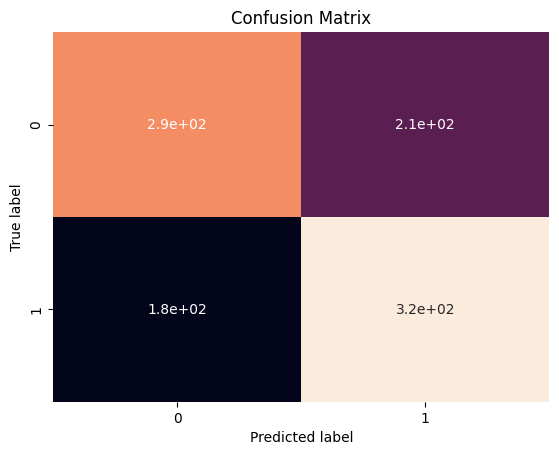

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       500
           1       0.60      0.64      0.62       500

    accuracy                           0.61      1000
   macro avg       0.61      0.61      0.61      1000
weighted avg       0.61      0.61      0.61      1000

__________vqvae__________
Accuracy 0.506
Precision: 0.438000
Recall: 0.506944
F1 score: 0.469957


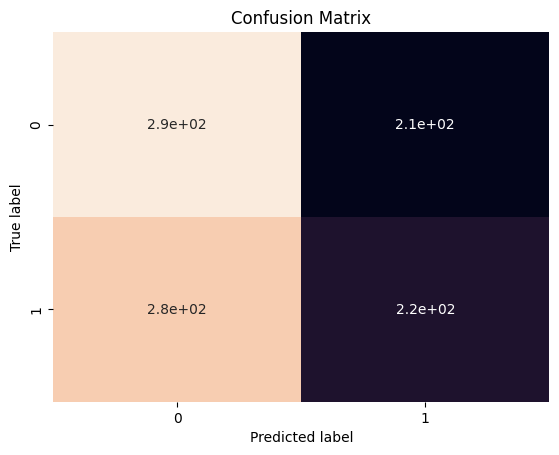

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       500
           1       0.51      0.44      0.47       500

    accuracy                           0.51      1000
   macro avg       0.51      0.51      0.50      1000
weighted avg       0.51      0.51      0.50      1000



In [23]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_elm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))

## Testing SVM

__________ 152_full __________
__________gen__________
Accuracy 0.969
Precision: 0.972000
Recall: 0.966203
F1 score: 0.969093


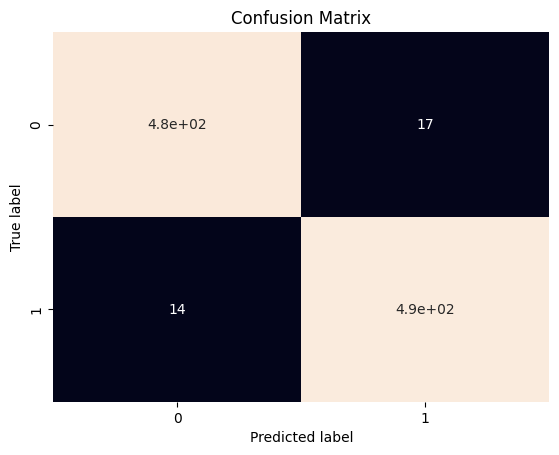

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       500
           1       0.97      0.97      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

__________ec__________
Accuracy 0.983
Precision: 1.000000
Recall: 0.967118
F1 score: 0.983284


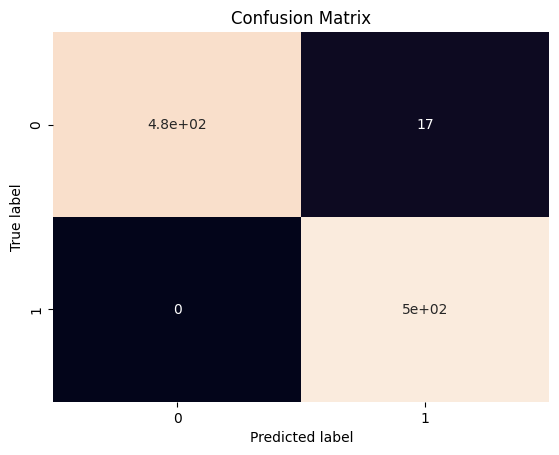

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       500
           1       0.97      1.00      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

__________vqvae__________
Accuracy 0.982
Precision: 0.998000
Recall: 0.967054
F1 score: 0.982283


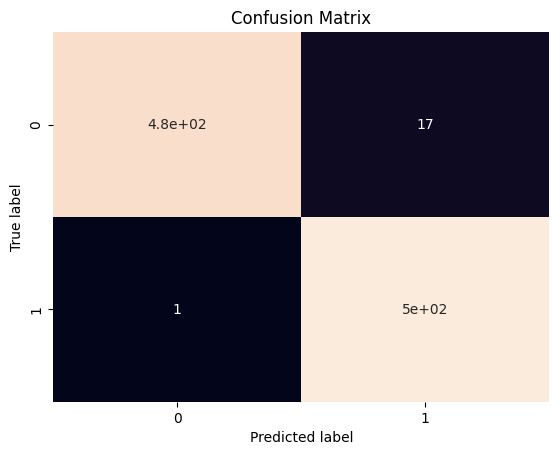

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       500
           1       0.97      1.00      0.98       500

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

__________ 101_full __________
__________gen__________
Accuracy 0.988
Precision: 0.994000
Recall: 0.982213
F1 score: 0.988072


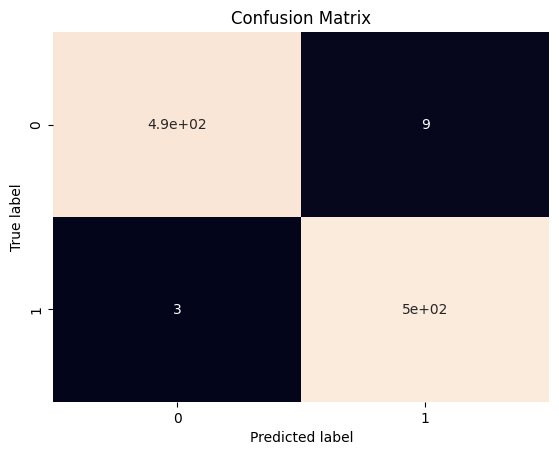

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       500
           1       0.98      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ec__________
Accuracy 0.991
Precision: 1.000000
Recall: 0.982318
F1 score: 0.991080


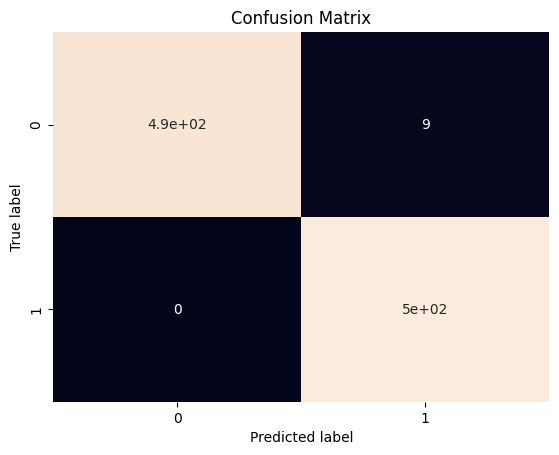

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________vqvae__________
Accuracy 0.989
Precision: 0.996000
Recall: 0.982249
F1 score: 0.989076


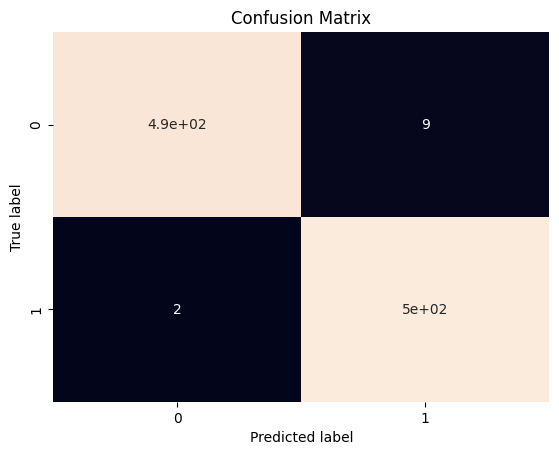

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ 50_full __________
__________gen__________
Accuracy 0.989
Precision: 0.994000
Recall: 0.984158
F1 score: 0.989055


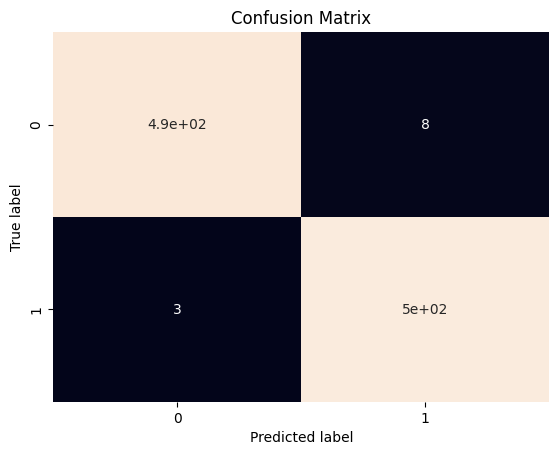

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       500
           1       0.98      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ec__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063


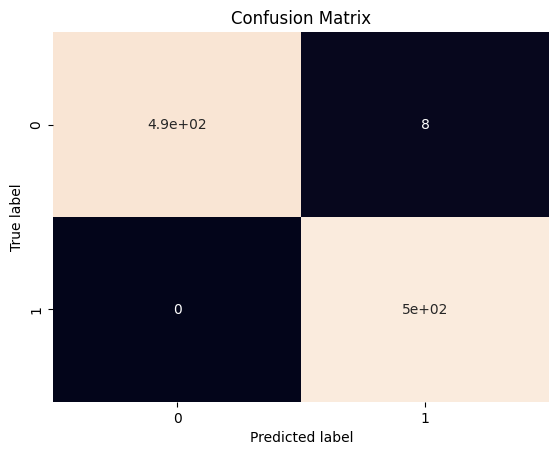

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________vqvae__________
Accuracy 0.992
Precision: 1.000000
Recall: 0.984252
F1 score: 0.992063


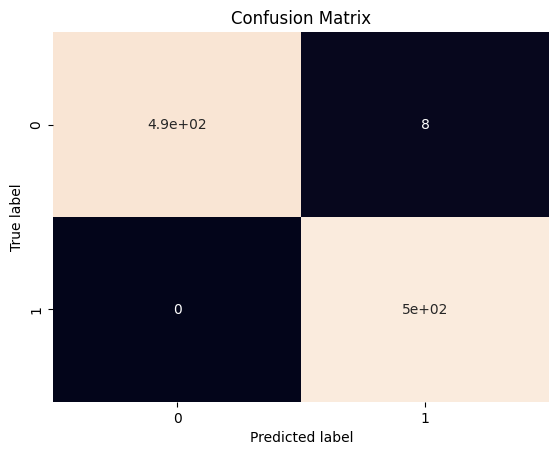

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       500
           1       0.98      1.00      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000

__________ 152_freeze __________
__________gen__________
Accuracy 0.744
Precision: 0.666000
Recall: 0.789100
F1 score: 0.722343


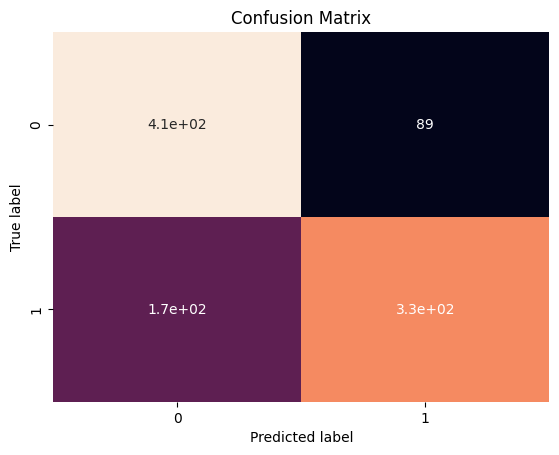

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       500
           1       0.79      0.67      0.72       500

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000

__________ec__________
Accuracy 0.906
Precision: 0.990000
Recall: 0.847603
F1 score: 0.913284


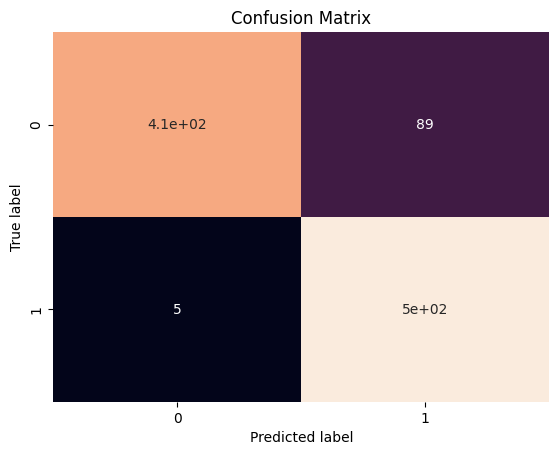

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       500
           1       0.85      0.99      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000

__________vqvae__________
Accuracy 0.882
Precision: 0.942000
Recall: 0.841071
F1 score: 0.888679


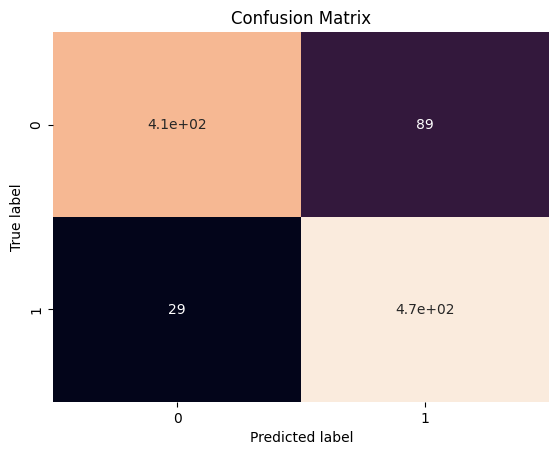

              precision    recall  f1-score   support

           0       0.93      0.82      0.87       500
           1       0.84      0.94      0.89       500

    accuracy                           0.88      1000
   macro avg       0.89      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000

__________ 101_freeze __________
__________gen__________
Accuracy 0.583
Precision: 0.572000
Recall: 0.584867
F1 score: 0.578362


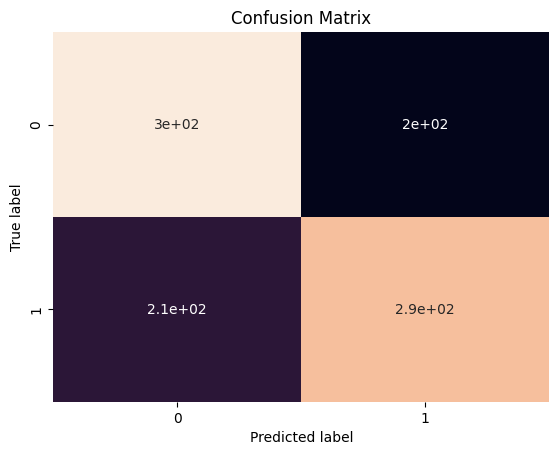

              precision    recall  f1-score   support

           0       0.58      0.59      0.59       500
           1       0.58      0.57      0.58       500

    accuracy                           0.58      1000
   macro avg       0.58      0.58      0.58      1000
weighted avg       0.58      0.58      0.58      1000

__________ec__________
Accuracy 0.71
Precision: 0.826000
Recall: 0.670455
F1 score: 0.740143


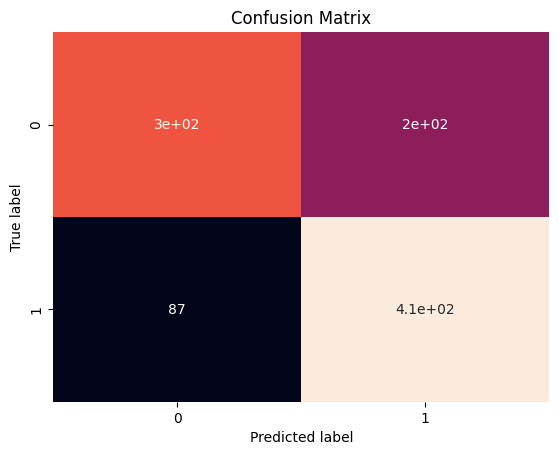

              precision    recall  f1-score   support

           0       0.77      0.59      0.67       500
           1       0.67      0.83      0.74       500

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.72      0.71      0.71      1000

__________vqvae__________
Accuracy 0.551
Precision: 0.508000
Recall: 0.555799
F1 score: 0.530825


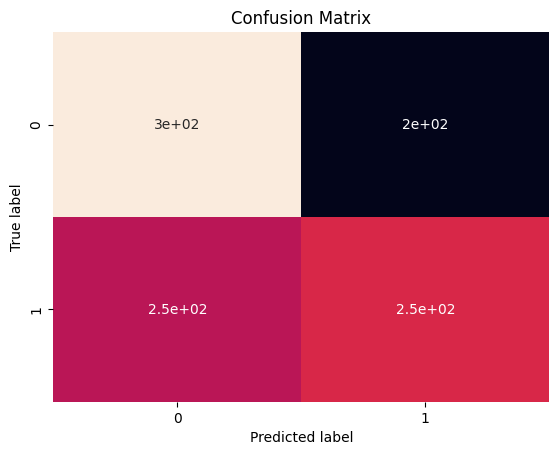

              precision    recall  f1-score   support

           0       0.55      0.59      0.57       500
           1       0.56      0.51      0.53       500

    accuracy                           0.55      1000
   macro avg       0.55      0.55      0.55      1000
weighted avg       0.55      0.55      0.55      1000

__________ 50_freeze __________
__________gen__________
Accuracy 0.572
Precision: 0.572000
Recall: 0.572000
F1 score: 0.572000


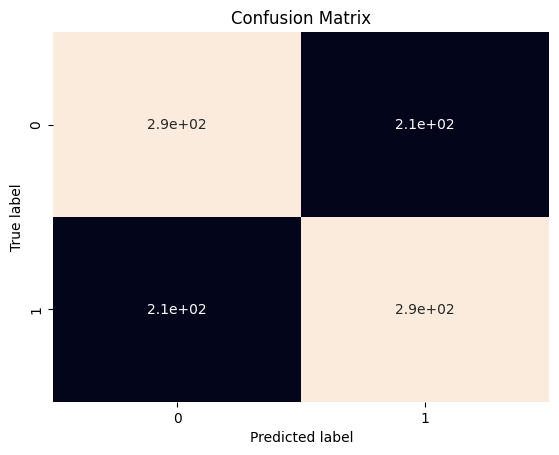

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       500
           1       0.57      0.57      0.57       500

    accuracy                           0.57      1000
   macro avg       0.57      0.57      0.57      1000
weighted avg       0.57      0.57      0.57      1000

__________ec__________
Accuracy 0.701
Precision: 0.830000
Recall: 0.659777
F1 score: 0.735164


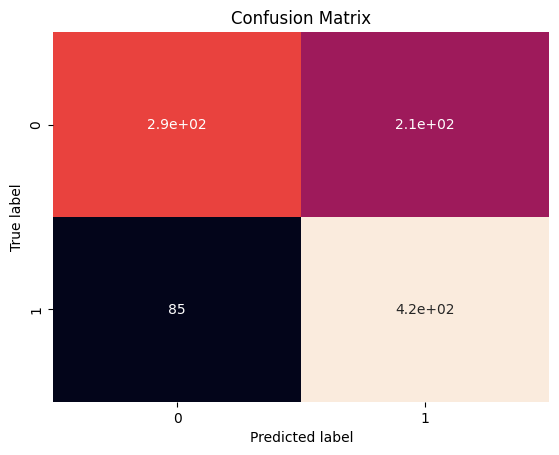

              precision    recall  f1-score   support

           0       0.77      0.57      0.66       500
           1       0.66      0.83      0.74       500

    accuracy                           0.70      1000
   macro avg       0.72      0.70      0.70      1000
weighted avg       0.72      0.70      0.70      1000

__________vqvae__________
Accuracy 0.538
Precision: 0.504000
Recall: 0.540773
F1 score: 0.521739


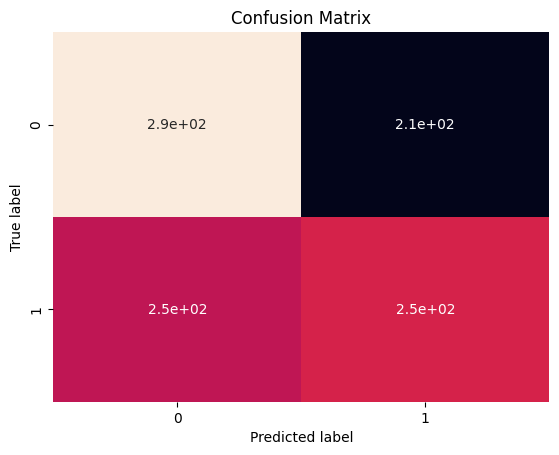

              precision    recall  f1-score   support

           0       0.54      0.57      0.55       500
           1       0.54      0.50      0.52       500

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.54      1000
weighted avg       0.54      0.54      0.54      1000



In [24]:
for model_name in model_softmax.keys():
  print("_"*10, model_name, "_"*10)

  for key in model_data[model_name].keys():
    Xtest = batch_predict(model_softmax[model_name].headless_model, model_data[model_name][key].images, 64)
    y_result = model_svm[model_name].predict(Xtest)

    labels = model_data[model_name][key].labels
    print(f"{'_'*10}{key}{'_'*10}")
    print("Accuracy", accuracy_score(y_result, labels))

    # precision tp / (tp + fp)
    precision = precision_score(y_result, labels)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_result, labels)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_result, labels)
    print('F1 score: %f' % f1)

    cm8 = confusion_matrix(labels, y_result)
    sns.heatmap(cm8, annot=True, cbar=False)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()
    print(classification_report(labels, y_result))